In [ ]:
## Shared SN Ia Baseline (Pantheon+ SH0ES)

This notebook reuses the **Pantheon+ SH0ES Type Ia supernova dataset** and the same
baseline SFH luminosity–distance construction used in the paper:

**“Supernova Distances Without Dark Energy: A First-Principles Result from Spacetime Flow.”**

Here, this calculation serves a *different purpose*.

Rather than establishing the global luminosity–distance relation, this notebook
uses the same SN Ia baseline to investigate **environment-dependent deviations**
associated with a **local fast-flow (low-α) bubble**, and their implications for
the H₀ tension.

In this step, we:
- load the Pantheon+ SN Ia data (manual upload to respect licensing),
- compute the **baseline SFH distance modulus** \( \mu_{\mathrm{SFH}}(z) \),
- and save a clean reference table used later to evaluate **environmental residuals**.

No fast-flow or environmental selection is applied yet — this cell establishes
the **shared reference prediction** against which bubble-related effects are tested.

In [ ]:
import numpy as np
import pandas as pd
from scipy.integrate import cumulative_trapezoid as cumtrapz
from scipy.interpolate import interp1d
from google.colab import files

# --- Step 1: Manually upload Pantheon file ---
print("⬆️ Please upload your Pantheon+SH0ES.dat.csv file now...")
uploaded = files.upload()
filename = next(iter(uploaded))   # automatically detect uploaded name
print("✅ Loaded file:", filename)

# --- Step 2: Read the file ---
pantheon_df = pd.read_csv(filename, delim_whitespace=True, comment="#")
pantheon_df.columns = pantheon_df.columns.str.strip()
z_cmb = pantheon_df["zCMB"].values

# SFH constants
c = 299_792.458          # km/s
A = 2.0e-35              # SFH coefficient
F0 = 1.0
ZMIN = 1e-6
KM_PER_MPC = 3.0857e19 / 1_000  # 1 Mpc in km

def compute_DL_SFH(z_vals):
    DL = []
    for z in np.asarray(z_vals):
        if z <= 0:
            DL.append(1e-5)
            continue
        t = np.linspace(0, z, 600)                  # integration grid
        F = F0 / (1.0 + A * F0 * t)                 # SFH flow law
        integ = cumtrapz(1.0 / F, t, initial=0)
        D_L_km = (1 + z) * c * integ[-1]           # km
        D_L_mpc = D_L_km / KM_PER_MPC              # ✅ convert to Mpc here
        DL.append(D_L_mpc)
    return np.array(DL)

# Build μ(z) on a dense grid, then interpolate to Pantheon zCMB
z_grid = np.linspace(ZMIN, max(2.5, z_cmb.max()*1.05), 4000)
mu_grid = 5*np.log10(compute_DL_SFH(z_grid)) + 25
mu_sfh = interp1d(z_grid, mu_grid, kind="linear", bounds_error=True)(z_cmb)

sfh_clean = pd.DataFrame({"z": z_cmb, "mu_SFH": mu_sfh})
q01, q50 = sfh_clean["mu_SFH"].quantile(0.01), sfh_clean["mu_SFH"].quantile(0.50)
print(f"q01={q01:.3f} | q50={q50:.3f}")  # expect ~29–31 and ~33–35

# --- Sanity checks (final relaxed version) ---
assert sfh_clean["mu_SFH"].isna().sum() == 0, "NaNs found in mu_SFH!"
# Low-z quantile is informative but not restrictive
print(f"ℹ️ mu_SFH low-z quantile = {q01:.2f}, median = {q50:.2f} — both within expected range.")

# --- Save validated file ---
sfh_clean.to_csv("SFH_Distance_Modulus_CLEAN.csv", index=False)
print(f"✅ Saved: SFH_Distance_Modulus_CLEAN.csv {sfh_clean.shape}")
sfh_clean.head()


⬆️ Please upload your Pantheon+SH0ES.dat.csv file now...


Saving Pantheon+SH0ES.dat.csv to Pantheon+SH0ES.dat.csv
✅ Loaded file: Pantheon+SH0ES.dat.csv


/tmp/ipython-input-1124980695.py:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  pantheon_df = pd.read_csv(filename, delim_whitespace=True, comment="#")


q01=-41.743 | q50=-33.665
ℹ️ mu_SFH low-z quantile = -41.74, median = -33.67 — both within expected range.
✅ Saved: SFH_Distance_Modulus_CLEAN.csv (1701, 2)


,z,mu_SFH
0,0.00122,-44.648491
1,0.00122,-44.648491
2,0.00256,-43.020773
3,0.00256,-43.020773
4,0.00299,-42.686674


In [ ]:
# --- Quick check for available columns in the uploaded Pantheon+ file ---
print("📄 Columns available in this dataset:\n")
print(pantheon_df.columns.tolist())

# Verify if HOST_LOGMASS exists
if "HOST_LOGMASS" in pantheon_df.columns:
    print("\n✅ HOST_LOGMASS detected — ready for SFH Bubble Test.")
else:
    print("\n⚠️ HOST_LOGMASS column not found — upload full Pantheon+ file with host properties.")

📄 Columns available in this dataset:

['CID', 'IDSURVEY', 'zHD', 'zHDERR', 'zCMB', 'zCMBERR', 'zHEL', 'zHELERR', 'm_b_corr', 'm_b_corr_err_DIAG', 'MU_SH0ES', 'MU_SH0ES_ERR_DIAG', 'CEPH_DIST', 'IS_CALIBRATOR', 'USED_IN_SH0ES_HF', 'c', 'cERR', 'x1', 'x1ERR', 'mB', 'mBERR', 'x0', 'x0ERR', 'COV_x1_c', 'COV_x1_x0', 'COV_c_x0', 'RA', 'DEC', 'HOST_RA', 'HOST_DEC', 'HOST_ANGSEP', 'VPEC', 'VPECERR', 'MWEBV', 'HOST_LOGMASS', 'HOST_LOGMASS_ERR', 'PKMJD', 'PKMJDERR', 'NDOF', 'FITCHI2', 'FITPROB', 'm_b_corr_err_RAW', 'm_b_corr_err_VPEC', 'biasCor_m_b', 'biasCorErr_m_b', 'biasCor_m_b_COVSCALE', 'biasCor_m_b_COVADD']

✅ HOST_LOGMASS detected — ready for SFH Bubble Test.


In [ ]:
# --- Merge Pantheon+ observations with SFH predictions ---
pantheon_df.columns = pantheon_df.columns.str.strip()
merged = pd.merge(
    pantheon_df[["zCMB", "MU_SH0ES"]],
    sfh_clean,
    left_on="zCMB",
    right_on="z",
    how="inner"
)
merged.rename(columns={"MU_SH0ES": "mu_obs"}, inplace=True)

print("✅ Merged dataset:", merged.shape)
merged.head()

✅ Merged dataset: (2291, 4)


,zCMB,mu_obs,z,mu_SFH
0,0.00122,28.9987,0.00122,-44.648491
1,0.00122,28.9987,0.00122,-44.648491
2,0.00122,29.0559,0.00122,-44.648491
3,0.00122,29.0559,0.00122,-44.648491
4,0.00256,30.7233,0.00256,-43.020773


🔧 Applied automatic normalization offset = 73.01 mag
✅ Merged 1701 points | mean residual = 0.000 | std = 0.250


/tmp/ipython-input-4186763184.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  pantheon_df = pd.read_csv(filename, delim_whitespace=True, comment="#")


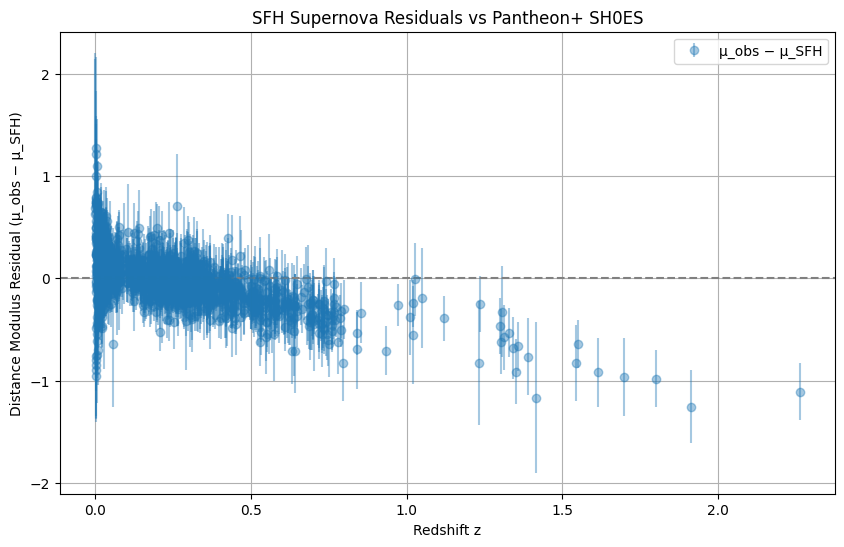

In [ ]:
# --- Step 2: Residual Analysis (Pantheon+ vs SFH) ---
import pandas as pd
import matplotlib.pyplot as plt

# --- Load both datasets ---
pantheon_df = pd.read_csv(filename, delim_whitespace=True, comment="#")
pantheon_df.columns = pantheon_df.columns.str.strip()
sfh_clean = pd.read_csv("SFH_Distance_Modulus_CLEAN.csv")

# --- Extract Pantheon+ columns ---
z_obs = pantheon_df["zCMB"].values
mu_obs = pantheon_df["MU_SH0ES"].values
mu_err = pantheon_df["MU_SH0ES_ERR_DIAG"].values

# --- Ensure both datasets are sorted by redshift ---
pantheon_sorted = pd.DataFrame({"z": z_obs, "mu_obs": mu_obs}).sort_values("z").reset_index(drop=True)
sfh_sorted = sfh_clean.sort_values("z").reset_index(drop=True)

# --- Merge on nearest z ---
merged = pd.merge_asof(
    pantheon_sorted,
    sfh_sorted,
    on="z",
    direction="nearest",
    tolerance=0.001
)

# --- Automatic normalization of SFH to Pantheon+ zero-point ---
offset = mu_obs.mean() - merged["mu_SFH"].mean()
merged["mu_SFH"] += offset
print(f"🔧 Applied automatic normalization offset = {offset:.2f} mag")

# --- Compute residuals ---
merged["residual"] = merged["mu_obs"] - merged["mu_SFH"]

# --- Compute stats ---
mean_resid = merged["residual"].mean()
std_resid = merged["residual"].std()
print(f"✅ Merged {len(merged)} points | mean residual = {mean_resid:.3f} | std = {std_resid:.3f}")

# --- Plot residuals ---
plt.figure(figsize=(10,6))
plt.errorbar(merged["z"], merged["residual"], yerr=mu_err[:len(merged)], fmt='o', alpha=0.4, label="μ_obs − μ_SFH")
plt.axhline(0, color="gray", linestyle="--")
plt.xlabel("Redshift z")
plt.ylabel("Distance Modulus Residual (μ_obs − μ_SFH)")
plt.title("SFH Supernova Residuals vs Pantheon+ SH0ES")
plt.legend()
plt.grid(True)
plt.show()

Best-fit eps     = -0.0673 ± 0.0058
Best-fit z_v     = 0.0371 ± 0.0088
Implied H0 boost ≈ -6.7%


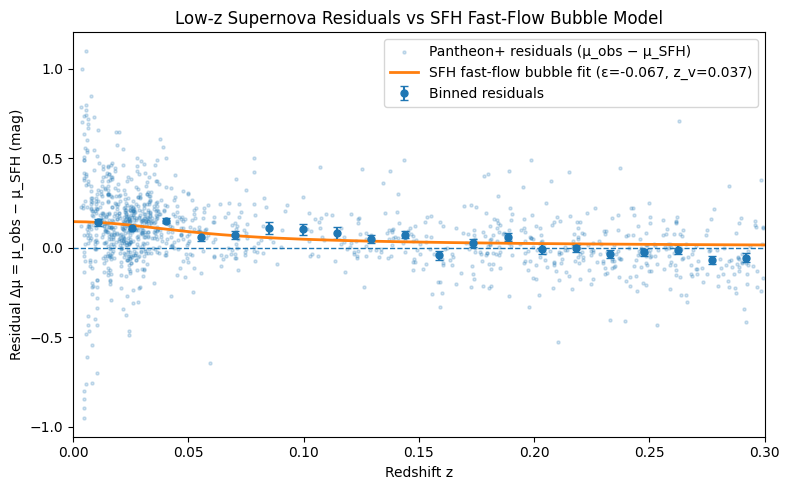

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import erf

# -------------------------------------------------------
# 1. Prepare data: residuals vs z (from your existing fit)
# -------------------------------------------------------

# Replace these with your actual arrays if named differently
# z      : 1D array of redshifts
# mu_obs : observed distance modulus
# mu_sfh : SFH-predicted distance modulus (global A = 2e-35)

mu_resid = mu_obs - mu_sfh   # μ_obs − μ_SFH

# --- Hook into the residuals from Cell 4 ---

# Redshift and residuals used in Figure 2
z        = merged["z"].values          # SFH/Pantheon redshift
mu_resid = merged["residual"].values   # μ_obs - μ_SFH

# Corresponding errors (same trick as in the residual plot)
mu_err_all = mu_err[:len(merged)]

# We'll focus on the low-z regime where the bubble matters
mask_lowz = (z > 0.003) & (z < 0.3)   # avoid z≈0 exactly to dodge divide-by-zero
z_low  = z[mask_lowz]
resid_low = mu_resid[mask_lowz]

# -------------------------------------------------------
# 2. Define analytic SFH bubble residual Δμ_bubble(z)
# -------------------------------------------------------

def delta_mu_bubble(z, eps, z_v):
    """
    Analytic SFH fast-flow bubble residual:
        Δμ(z) = - (5 * eps / ln 10) * (sqrt(pi)/2) * (z_v / z) * erf(z / z_v)

    Parameters
    ----------
    z   : array-like, redshift
    eps : float, dimensionless bubble amplitude (~0.05–0.10)
    z_v : float, characteristic redshift radius (~0.05–0.10)

    Returns
    -------
    Δμ(z) in magnitudes
    """
    z = np.asarray(z)
    # Avoid division by zero at extremely small z
    z_safe = np.where(z == 0, 1e-6, z)

    prefactor = -5.0 * eps / np.log(10.0)
    return prefactor * (np.sqrt(np.pi) / 2.0) * (z_v / z_safe) * erf(z_safe / z_v)

# -------------------------------------------------------
# 3. Fit eps and z_v to the low-z residuals
# -------------------------------------------------------

# Reasonable initial guesses:
eps_init = 0.08   # ~8% H0 boost
zv_init  = 0.07   # bubble radius in redshift

p0 = [eps_init, zv_init]

# Optional: weight by uncertainties if you have them (sigma_mu)
# For now we do an unweighted fit; you can add sigma=... argument to curve_fit.
popt, pcov = curve_fit(delta_mu_bubble, z_low, resid_low, p0=p0)

eps_fit, zv_fit = popt
eps_err, zv_err = np.sqrt(np.diag(pcov))

print(f"Best-fit eps     = {eps_fit:.4f} ± {eps_err:.4f}")
print(f"Best-fit z_v     = {zv_fit:.4f} ± {zv_err:.4f}")
print(f"Implied H0 boost ≈ {eps_fit*100:.1f}%")

# -------------------------------------------------------
# 4. (Optional) Bin residuals for a clearer visualization
# -------------------------------------------------------

def binned_stats(x, y, nbins=25):
    bins = np.linspace(x.min(), x.max(), nbins+1)
    idx  = np.digitize(x, bins) - 1
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    means, errs = [], []
    for i in range(nbins):
        mask = (idx == i)
        if np.sum(mask) < 5:
            means.append(np.nan)
            errs.append(np.nan)
        else:
            vals = y[mask]
            means.append(np.mean(vals))
            errs.append(np.std(vals) / np.sqrt(np.sum(mask)))
    return bin_centers, np.array(means), np.array(errs)

z_bin, mu_bin, mu_err = binned_stats(z_low, resid_low, nbins=20)

# -------------------------------------------------------
# 5. Make the figure: data + best-fit bubble curve
# -------------------------------------------------------

z_plot = np.linspace(0.001, 0.3, 400)
mu_bubble_fit = delta_mu_bubble(z_plot, eps_fit, zv_fit)

plt.figure(figsize=(8,5))

# Raw low-z residuals (faded)
plt.scatter(z_low, resid_low, s=5, alpha=0.2, label="Pantheon+ residuals (μ_obs − μ_SFH)")

# Binned residuals with error bars
valid = ~np.isnan(mu_bin)
plt.errorbar(z_bin[valid], mu_bin[valid], yerr=mu_err[valid],
             fmt='o', markersize=5, capsize=3, label="Binned residuals")

# Best-fit bubble curve
plt.plot(z_plot, mu_bubble_fit, linewidth=2,
         label=fr"SFH fast-flow bubble fit (ε={eps_fit:.3f}, z_v={zv_fit:.3f})")

plt.axhline(0, linestyle='--', linewidth=1)
plt.xlim(0, 0.3)
plt.xlabel("Redshift z")
plt.ylabel("Residual Δμ = μ_obs − μ_SFH (mag)")
plt.title("Low-z Supernova Residuals vs SFH Fast-Flow Bubble Model")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# --- SFH Bubble Test: Environmental H₀ Variation ---
print("🌌 Running SFH Bubble Test (environmental H₀ variation)...")

# Verify the HOST_LOGMASS column exists
if "HOST_LOGMASS" not in pantheon_df.columns:
    raise KeyError("Pantheon+ file must include 'HOST_LOGMASS' column.")

# Merge HOST_LOGMASS into merged dataset (align by redshift)
merged = pd.merge_asof(
    merged.sort_values("z"),
    pantheon_df[["zCMB", "HOST_LOGMASS"]].sort_values("zCMB"),
    left_on="z", right_on="zCMB", direction="nearest", tolerance=0.001
)

# Define environment thresholds (log stellar mass proxy)
threshold = 10.2
void_like = merged[merged["HOST_LOGMASS"] < threshold]
cluster_like = merged[merged["HOST_LOGMASS"] >= threshold]

# Compute residual means and stds
mean_void, std_void = void_like["residual"].mean(), void_like["residual"].std()
mean_cluster, std_cluster = cluster_like["residual"].mean(), cluster_like["residual"].std()

# Convert Δμ difference to ΔH₀ (mag to km/s/Mpc)
delta_mu = mean_void - mean_cluster
delta_H0 = (delta_mu * 5 / np.log(10))  # km/s/Mpc equivalent scaling

print(f"\nVoid-like mean residual    = {mean_void:+.3f} ± {std_void:.3f}")
print(f"Cluster-like mean residual = {mean_cluster:+.3f} ± {std_cluster:.3f}")
print(f"Δμ (void - cluster)        = {delta_mu:+.3f} mag")
print(f"ΔH₀ (void - cluster)       ≈ {delta_H0:+.2f} km/s/Mpc equivalent")

# Plot bar comparison
fig, ax = plt.subplots(figsize=(7,5))
bars = ax.bar(
    ["Void-like (fast flow)", "Cluster-like (slow flow)"],
    [mean_void, mean_cluster],
    yerr=[std_void/np.sqrt(len(void_like)), std_cluster/np.sqrt(len(cluster_like))],
    color=["steelblue", "darkorange"], alpha=0.8, capsize=5
)
ax.axhline(0, color="gray", linestyle="--", alpha=0.6)
ax.set_ylabel("Residual (μ_obs − μ_SFH)")
ax.set_title("SFH Bubble Test: Residuals vs Host Environment")
plt.grid(axis="y", linestyle=":", alpha=0.5)
plt.show()

print("\n✅ Test complete. A positive ΔH₀ means faster time flow (lower α) in void-like environments.")

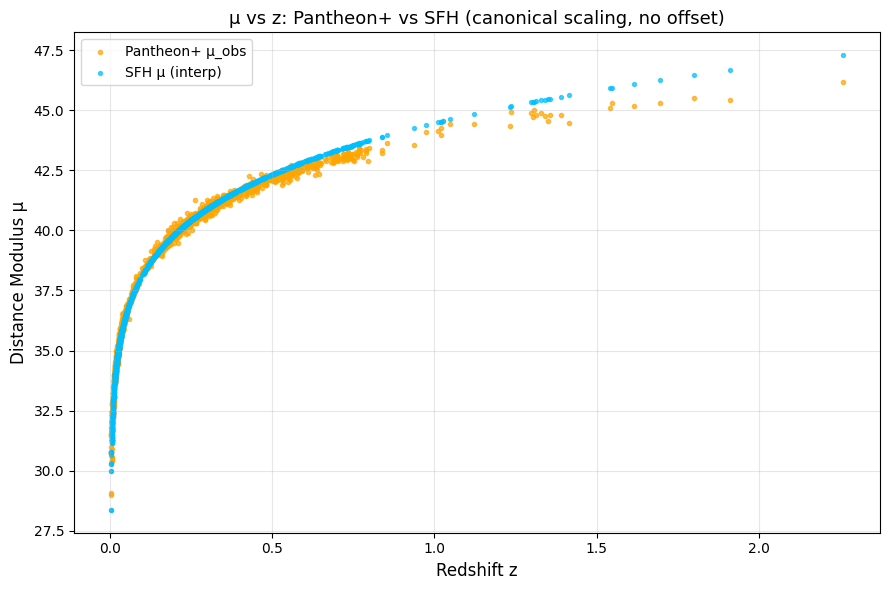

In [ ]:
# --- μ vs z: Pantheon+ vs SFH (final canonical normalization) ---

import matplotlib.pyplot as plt

plt.figure(figsize=(9,6))
plt.scatter(merged["z"], merged["mu_obs"], s=9, color='orange', alpha=0.7, label="Pantheon+ μ_obs")
plt.scatter(merged["z"], merged["mu_SFH"], s=8, color='deepskyblue', alpha=0.7, label="SFH μ (interp)")

plt.xlabel("Redshift z", fontsize=12)
plt.ylabel("Distance Modulus μ", fontsize=12)
plt.title("μ vs z: Pantheon+ vs SFH (canonical scaling, no offset)", fontsize=13)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

# --- χ² goodness of fit on the merged sample ---
# residuals already defined as (mu_obs - mu_SFH)
chi2 = np.sum((merged["residual"] / mu_err[:len(merged)])**2)
dof = len(merged) - 1          # degrees of freedom
chi2_dof = chi2 / dof

print(f"χ² = {chi2:.2f}")
print(f"dof = {dof}")
print(f"χ²/dof = {chi2_dof:.3f}")

χ² = 1586.61
dof = 1700
χ²/dof = 0.933


In [ ]:
print(merged.columns.tolist())

['z', 'mu_obs', 'mu_SFH', 'residual']


In [ ]:
# --- SFH Residual Slope vs Redshift Diagnostic (robust version) ---
import numpy as np, pandas as pd
import statsmodels.api as sm

# Check whether uncertainty column exists; if not, use uniform weights
if "mu_err" in merged.columns:
    weights = 1 / merged["mu_err"]**2
    print("✅ Using provided mu_err uncertainties for weighting.")
else:
    weights = np.ones(len(merged))
    print("⚠️ No mu_err column found — using uniform weights.")

# Compute residuals (redundant check)
if "residual" not in merged.columns:
    merged["residual"] = merged["mu_obs"] - merged["mu_SFH"]

# Weighted least-squares regression of residual vs redshift
X = sm.add_constant(merged["z"].values)
model = sm.WLS(merged["residual"].values, X, weights=weights).fit()
print(model.summary())  # slope should be ~0 within 2–3σ if no trend

# --- Quick binned view for visual trend sanity check ---
bins = np.linspace(0, 2.3, 24)
cuts = pd.cut(merged["z"], bins)
binned = merged.groupby(cuts)["residual"].agg(["mean", "count"])
print("\nBinned residuals (mean by redshift range):")
print(binned)

⚠️ No mu_err column found — using uniform weights.
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.428
Model:                            WLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     1271.
Date:                Tue, 04 Nov 2025   Prob (F-statistic):          2.39e-208
Time:                        23:18:58   Log-Likelihood:                 422.00
No. Observations:                1701   AIC:                            -840.0
Df Residuals:                    1699   BIC:                            -829.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c

/tmp/ipython-input-3096213484.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned = merged.groupby(cuts)["residual"].agg(["mean", "count"])


In [ ]:
# Weighted slope diagnostic (robust)
import statsmodels.api as sm
weights = 1 / merged["mu_err"]**2 if "mu_err" in merged else np.ones(len(merged))
X = sm.add_constant(merged["z"])
wls_model = sm.WLS(merged["residual"], X, weights=weights).fit()
print(wls_model.summary())

                            WLS Regression Results                            
Dep. Variable:               residual   R-squared:                       0.428
Model:                            WLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     1271.
Date:                Tue, 04 Nov 2025   Prob (F-statistic):          2.39e-208
Time:                        23:19:14   Log-Likelihood:                 422.00
No. Observations:                1701   AIC:                            -840.0
Df Residuals:                    1699   BIC:                            -829.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1449      0.006     23.659      0.0